## Import Packages 

In [52]:
import pandas as pd 
import requests
import io
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain 
from matplotlib.pyplot import figure

## Import Datasets

In [2]:
df_covid = pd.read_csv('Datasets/COVID-19_Statistics_by_Jurisdiction.csv')
#https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-jurisdiction?geometry=-120.348%2C32.566%2C-115.965%2C33.372
df_population = pd.read_csv('Datasets/sub-est2019_6.csv', encoding = 'latin-1')
ca_population = pd.read_csv('Datasets/sub-est2019_6.csv', encoding = 'latin-1')
ca_covid = pd.read_csv('Datasets/statewide_cases.csv')
#https://data.ca.gov/dataset/covid-19-cases/resource/926fd08f-cc91-4828-af38-bd45de97f8c3


## Data Cleaning

In [3]:
## changing covid's lastupdate to just the date 
lastUpdate = df_covid['lastupdate']
update = []
for t in lastUpdate:
    ##getting rid of the time 
    date = t.split(' ')[0]
    #print(date)
    update.append(datetime.strptime(date, '%Y/%m/%d'))

df_covid['date'] = update

In [4]:
## adding day of the week to df covid 
weekday = []
for d in df_covid['date']:
    weekday.append(str(d.isoweekday()))


df_covid['dayOfWeek'] = weekday

In [5]:
##convert time into str for date 
new_date =[]
for e in df_covid.loc[:, 'date']:
    new_date.append(e.strftime('%m-%d'))

df_covid['date'] = new_date

In [6]:
##leaving only the useful columns  for covid
cols = ['name', 'confirmedcases', 'date', 'dayOfWeek']
df_covid = df_covid[cols]

In [7]:
##cleaning Name to title 
df_covid['name'] = df_covid['name'].str.title()
df_covid.rename({'name' : 'City'}, inplace = True, axis = 1)

In [8]:
##check for null values 
df_covid.isnull().sum()

City                0
confirmedcases    139
date                0
dayOfWeek           0
dtype: int64

In [9]:
##City is Unknown, most likely an input error
df_covid = df_covid.dropna()

In [10]:
## inspect City == Unknown 
len(df_covid[df_covid['City'] == 'Unknown'])

135

In [11]:
## retaining neighboring cities in California for even-level visualization 
cities_list = ['San Diego','San Francisco', 'Riverside', 'Imperial', 'Los Angeles', 'Sacramento', 'Orange', 'Santa Clara']
ca_covid = ca_covid.loc[ca_covid['county'].isin(cities_list)]

In [12]:
## clean date columns
ca_covid['date'] = ca_covid['date'].str.replace('2020-','').str.replace('T00:00:00', '')

## Data Visualization

In [13]:
##helper function to determine if desired city is in dataset 
def find_city(city): 
    city = city.title()
    print(city in df_covid['City'].unique())
    

In [14]:
##group by date and graph in san diego
df_sd = df_covid.loc[df_covid['City'] == 'San Diego', :]
group_date = df_sd.groupby('date')
sd_daily_count = group_date[['confirmedcases', 'date']].sum()


In [15]:
## get daily count in SD
df_sd = df_sd.sort_values('date')
diff = df_sd['confirmedcases'] - df_sd['confirmedcases'].shift(1)
df_sd['DailyCases'] = diff


In [16]:
## make new columns that's the difference between confirmed cases to get 
## daily count 
df_sd = df_sd.sort_values('date')
df_sd.set_index('date')

,City,confirmedcases,dayOfWeek,DailyCases
date,,,,
03-20,San Diego,87.0,5,NaN
03-21,San Diego,118.0,6,31.0
03-22,San Diego,134.0,7,16.0
03-23,San Diego,141.0,1,7.0
03-24,San Diego,169.0,2,28.0
...,...,...,...,...
12-14,San Diego,43972.0,1,635.0
12-15,San Diego,44881.0,2,909.0
12-16,San Diego,45716.0,3,835.0


In [17]:
##deploy pivot table to aggregate daily cases
sd_pv = df_sd.pivot_table(index = 'date', values = 'DailyCases')

<AxesSubplot:title={'center':'COVID in SD from 10-20 to 12-18'}, xlabel='date'>

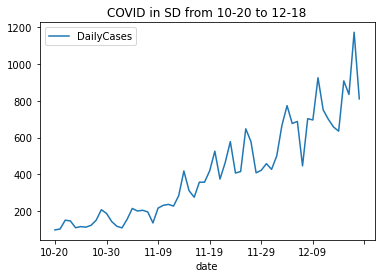

In [18]:
## graph last 14 days in sd 
sd_pv[-60:].plot(kind = 'line', title='COVID in SD from {} to {}'.format(sd_pv.index[-60], sd_pv.index[-1]))

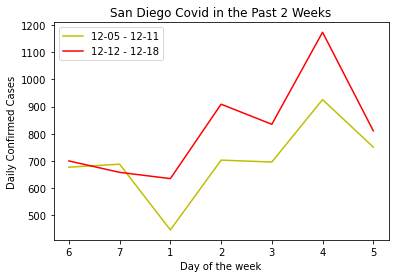

In [19]:
## could fix this so the two graphs overlap, and use the day 
## of the week as x axis
df_sd_twoweeks_before = df_sd[['dayOfWeek', 'DailyCases']].iloc[-14:-7]
df_sd_oneweek_before = df_sd[['dayOfWeek', 'DailyCases']].iloc[-7:]

plt.plot(df_sd_twoweeks_before['dayOfWeek'], df_sd_twoweeks_before['DailyCases'], label = '{} - {}'.format(df_sd['date'].iloc[-14], df_sd['date'].iloc[-8]), c = 'y')
plt.plot(df_sd_oneweek_before['dayOfWeek'], df_sd_oneweek_before['DailyCases'], label = '{} - {}'.format(df_sd['date'].iloc[-7], df_sd['date'].iloc[-1]), c = 'r')
plt.title('San Diego Covid in the Past 2 Weeks')
plt.ylabel('Daily Confirmed Cases')
plt.xlabel('Day of the week')
plt.legend()

In [20]:
weekday_sd_pv = df_sd.pivot_table(index = 'dayOfWeek', values = 'DailyCases')

Text(0.5, 0, 'Day of Week')

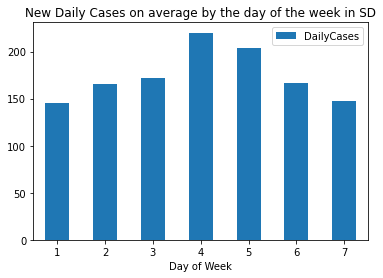

In [21]:
ax = weekday_sd_pv.plot(kind='bar', rot = 0, title = 'New Daily Cases on average by the day of the week in SD')
ax.set_xlabel('Day of Week')

## Comparing SD to nearby Cities 

In [23]:
df_population = df_population[['NAME', 'POPESTIMATE2019']]
df_population.columns = ['City', 'Population']

In [24]:
##clean City column 
df_population['City'] = df_population['City'].str.replace('city', '')
df_population['City'] = df_population['City'].str.replace('town', '')
df_population['City'] = df_population['City'].str.strip()
df_population.drop_duplicates(inplace = True)

In [25]:
##getting df population with only cities in df_covid
cities = df_covid['City'].unique()
df_population = df_population[df_population['City'].isin(list(cities))]
df_population = df_population[['City', 'Population']]

In [26]:
## merging these datasets 
df_covid_pop = df_population.merge(df_covid, left_on='City', right_on='City', how = 'inner')
df_covid_pop = df_covid_pop.sort_values(by=['City', 'date'])
cities = list(df_covid_pop['City'].unique())

In [27]:
daily = []
for c in list(cities):
    df_temp = df_covid_pop.loc[df_covid_pop['City'] == c, :]
    diff = df_temp['confirmedcases'] - df_temp['confirmedcases'].shift(1)
    daily.append(list(diff))

daily = list(chain.from_iterable(daily))
df_covid_pop['DailyCases'] = daily

In [28]:
## creating confirmed cases per million column 
df_covid_pop['DailyCases/Million'] = (df_covid_pop['DailyCases']/df_covid_pop['Population']*1000000)

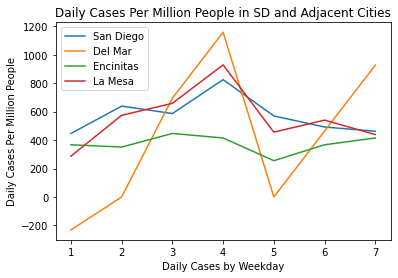

In [29]:
## Visualizing Cities in SD area in the past week by DailyCases/Million
## target adjacent cities 
ad_cities = ['San Diego', 'Del Mar', 'Encinitas', 'La Mesa']

for c in list(ad_cities):
    df_temp = df_covid_pop.loc[df_covid_pop['City'] == c, :]
    pv_temp = df_temp.iloc[-7:].pivot_table(index = 'dayOfWeek', values = 'DailyCases/Million')
    plt.plot(pv_temp, label = c)
    plt.ylabel("Daily Cases Per Million People" )
    plt.xlabel('Daily Cases by Weekday')
    plt.title('Daily Cases Per Million People in SD and Adjacent Cities')
    plt.legend()

Cannot draw reasonable conclusion to the graph above, so I'm proceeding with comparing major cities in Socal

## Comparing San Diego to other major cities

Here, I will create a helper function that takes in 2 parameters: the targeted cities to be compared, and the amount of days to be shown. The function then creates a visualization of the new daily cases per million people across the targeted cities. 

In [31]:
ca_population = ca_population[['NAME', 'POPESTIMATE2019']]
ca_population.columns = ['City', 'Population']

##clean City column 
ca_population['City'] = ca_population['City'].str.replace('city', '')
ca_population['City'] = ca_population['City'].str.replace('town', '')
ca_population['City'] = ca_population['City'].str.strip()
ca_population.drop_duplicates(inplace = True)


##getting df population with only cities in df_covid
ca_cities = cities_list
ca_population = ca_population[ca_population['City'].isin(list(ca_cities))]
ca_population = ca_population[['City', 'Population']]

## merging these datasets 
ca_covid = ca_population.merge(ca_covid, left_on='City', right_on='county', how = 'inner')
ca_covid = ca_covid.sort_values(by=['City', 'date'])
#cities = list(df_covid_pop['City'].unique())
#cities

In [32]:
ca_covid['DailyCases/Million'] = (ca_covid['newcountconfirmed']/df_covid_pop['Population']*1000000)

In [34]:
cities_list

['San Diego',
 'San Francisco',
 'Riverside',
 'Imperial',
 'Los Angeles',
 'Sacramento',
 'Orange',
 'Santa Clara']

In [53]:
def cal_covid(cities_list, days_before):
    aval = list(ca_covid['City'].unique())
    figure(figsize=(8,6))
    for c in list(cities_list):
        if c not in aval:
            print(c +" is not in the dataset")
            continue

        df_temp = ca_covid.loc[ca_covid['City'] == c, :]
        #print(df_temp)
        pv_temp = df_temp.iloc[-days_before:].pivot_table(index = 'date', values = 'DailyCases/Million')
        
        plt.plot(pv_temp, label = c)
        plt.ylabel("Daily Cases Per Million People" )
        plt.xlabel('Daily Cases by Weekday')
        plt.title('Daily Cases Per Million People in SD and Adjacent Cities')
        plt.legend()

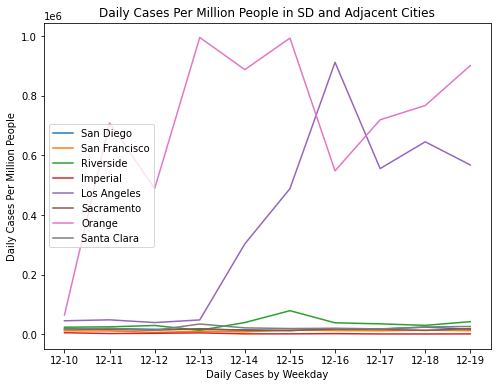

In [59]:
cal_covid(cities_list, 10)

In [55]:
cities_list_without_LA = ['San Diego',
 'San Francisco',
 'Imperial',
 'Sacramento',
 'Santa Clara']

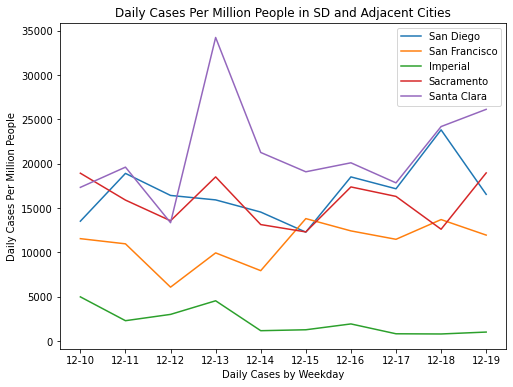

In [57]:
cal_covid(cities_list_without_LA, 10)

Compared to other major counties, especially LA and Orange County, San Diego seemingly has been keeping its new Positive Cases relatively low. However, excluding those two outliers in LA and Orange County, San Diego saw its biggest increase in mid June, two weeks after the stay at home order was alleviated, and dropped down gradually to an average level in mid July, one week after in door businesses were ordered to close down. 

## Hypothesis Testing 

San Diego entered phase 2 of reopening at 6/12. This includes the reopenning of public places like gyms, bars, museums and hotels. There is much speculation that this action would direct cause an increase of cases. While visualization supports the claim, null hypothesis testing would be needed to take place in order to obtain statistical evidence. Here, I compare the two groups, between the lock down and the reopenning(3/19 - 6/12), and between the reopening to today (6/12-6/28)

Null Hypothesis: the increase in COVID positive rate after is a result of random fluctuation, H0 = 0

Alternatvie Hypothesis: the increase in COVID positive rate this week is not a result of random fluctuation, H1 != 0

By random fluctuation, it is interpreted with the assumption that the average postive cases by day in San Diego stays relatively constant after the lockdown. This is supported by graphing the COVID daily cases in San Diego, where cases had been oscillating firmly around 75 cases a day since 3/19, the date where California issued a stay at home order. 

In [40]:
## get the weekly average between the stay at home order and reopen 
## reindex 
index_list = []
index_list = list(range(0, len(df_sd)))
df_sd.index = index_list
## get index of day of stay at home order
start = df_sd[df_sd['date'] == '03-20'].index
end = df_sd[df_sd['date'] == '06-12'].index

##get the df for stay at home order
df_sd_stay_at_home = df_sd.iloc[start[0]: end[0]]

## get the df for reopening 
df_sd_reopen = df_sd.iloc[end[0]:]

In [41]:
## get pv table for daily averages per day of week for df_stay_at_home and df_reopen
pv_weekday_sd_stay_at_home = df_sd_stay_at_home.pivot_table(index = 'dayOfWeek', values = 'DailyCases')
pv_weekday_sd_reopen = df_sd_reopen.pivot_table(index = 'dayOfWeek', values = 'DailyCases')


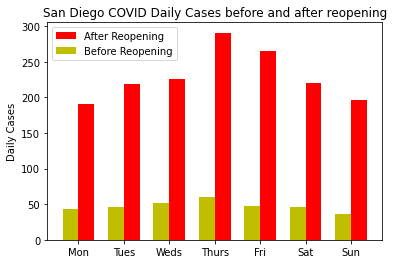

In [42]:
## graphing the two 
N = 7
ind = pv_weekday_sd_reopen.index  # the x locations for the groups
width = 0.35       # the width of the bars
pos = np.arange(N)+1
fig,ax = plt.subplots()

## creating rectangles for ax
rects1 = ax.bar(pos+width, pv_weekday_sd_reopen['DailyCases'], width, color = 'r')
rects2 = ax.bar(pos, pv_weekday_sd_stay_at_home['DailyCases'], width, color = 'y')

ax.set_ylabel('Daily Cases')
ax.set_title('San Diego COVID Daily Cases before and after reopening')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(('Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'))

ax.legend((rects1[0], rects2[0]), ('After Reopening', 'Before Reopening'))

In [45]:
## conduct 1 tail student t test 
t, p = stats.ttest_ind(df_sd_stay_at_home['DailyCases'], df_sd_reopen['DailyCases'], nan_policy='omit')
print('The T Score is {:.2f}, and the P-value is {:.2f}'.format(t, p))

The T Score is -8.46, and the P-value is 0.00
